1. Gerekli kütüphaneler

In [10]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

2. Veriyi okuma

In [11]:
# Verileri oku
train_df = pd.read_csv("../datasets/pca/train_mental_pca.csv")
test_df = pd.read_csv("../datasets/pca/test_mental_pca.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("support_needed", axis=1)
y_train = train_df["support_needed"]

X_test = test_df.drop("support_needed", axis=1)
y_test = test_df["support_needed"]

print("✅ Eğitim verisi:", X_train.shape)
print("✅ Test verisi:", X_test.shape)
print("🎯 Sınıf dağılımı (y_train):\n", pd.Series(y_train).value_counts())

✅ Eğitim verisi: (1007, 23)
✅ Test verisi: (252, 23)
🎯 Sınıf dağılımı (y_train):
 support_needed
0    528
1    479
Name: count, dtype: int64


In [12]:
print("🎯 Orijinal sınıf dağılımı:", Counter(y_train))

🎯 Orijinal sınıf dağılımı: Counter({0: 528, 1: 479})


In [13]:
# 2️⃣ Sadece sayısal olmayan sütunlar encode edilmiş varsayılıyor. Tamamını ölçekle.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
# 3️⃣ SMOTE ile oversampling
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("⚖️ Dengelenmiş eğitim sınıf dağılımı:", Counter(y_train_balanced))

⚖️ Dengelenmiş eğitim sınıf dağılımı: Counter({0: 528, 1: 528})


In [14]:
y_train_cat = to_categorical(y_train_balanced)
y_test_cat = to_categorical(y_test)

3. ANN modeli

In [15]:
# ANN mimarisi
model = Sequential([
    Input(shape=(X_train_balanced.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # 2 sınıf için softmax
])

# Derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,682 (14.38 KB)

 Trainable params: 3,682 (14.38 KB)

 Non-trainable params: 0 (0.00 B)

4. Model eğitimi

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_balanced,  
    y_train_cat,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5903 - loss: 1.0113 - val_accuracy: 0.7500 - val_loss: 0.4929
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6995 - loss: 0.6305 - val_accuracy: 0.7972 - val_loss: 0.4344
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7346 - loss: 0.5572 - val_accuracy: 0.8160 - val_loss: 0.4109
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7695 - loss: 0.4937 - val_accuracy: 0.8208 - val_loss: 0.3979
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7466 - loss: 0.5145 - val_accuracy: 0.8208 - val_loss: 0.3998
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7633 - loss: 0.4948 - val_accuracy: 0.8160 - val_loss: 0.3939
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8234 - loss: 0.4379 - val_accuracy: 0.8255 - val_loss: 0.3953
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7503 - loss: 0.5417 - val_accuracy: 0.8302 - v

5. Tahmin, rapor ve görselleştirme

In [17]:
# Tahmin (olasılıklar)
y_pred_proba = model.predict(X_test_scaled)

# En yüksek olasılığa göre sınıf tahmini
y_pred = y_pred_proba.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


📋 Sınıflandırma Raporu (ANN):

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       132
           1       0.79      0.78      0.79       120

    accuracy                           0.80       252
   macro avg       0.80      0.80      0.80       252
weighted avg       0.80      0.80      0.80       252



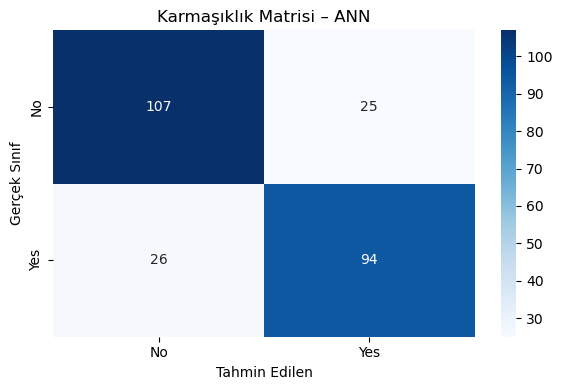

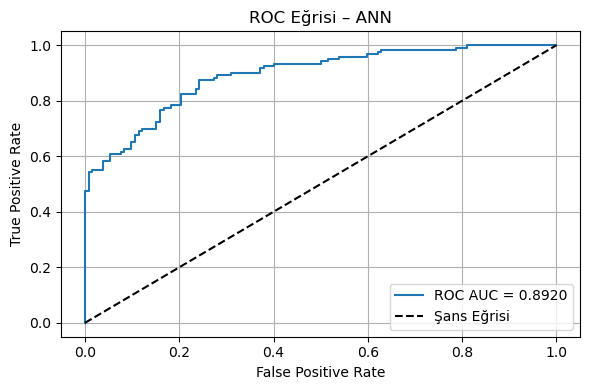

In [18]:
# Rapor
print("📋 Sınıflandırma Raporu (ANN):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – ANN")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# Sadece pozitif sınıfın (1) olasılığı alınır
y_score = y_pred_proba[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Çizim
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--', label="Şans Eğrisi")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi – ANN")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()